In [76]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [77]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [78]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect


In [79]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [80]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(autoload_with=engine)

# reflect the tables
measurement_data = engine.execute("SELECT * FROM measurement LIMIT 5")
station_data = engine.execute("SELECT * FROM station LIMIT 5")

print('measurement data sample:')
for record in measurement_data:
        print(record)

print('\nstation data sample:')
for record2 in station_data:
    print(record2)

measurement data sample:
(1, 'USC00519397', '2010-01-01', 0.08, 65.0)
(2, 'USC00519397', '2010-01-02', 0.0, 63.0)
(3, 'USC00519397', '2010-01-03', 0.0, 74.0)
(4, 'USC00519397', '2010-01-04', 0.0, 76.0)
(5, 'USC00519397', '2010-01-06', None, 73.0)

station data sample:
(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)
(2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6)
(3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)
(4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)
(5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)


In [81]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [82]:
# Inspect the type of data
inspector = inspect(engine)
print('measurement Data Types')
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])
print('\nstation Data Types')
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

measurement Data Types
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

station Data Types
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [83]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [84]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [85]:
# Find the most recent date in the data set.
most_recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
most_recent_date

('2017-08-23',)

Start date of dataset: 2016-08-23
First entry: ('2016-08-24', 0.08)


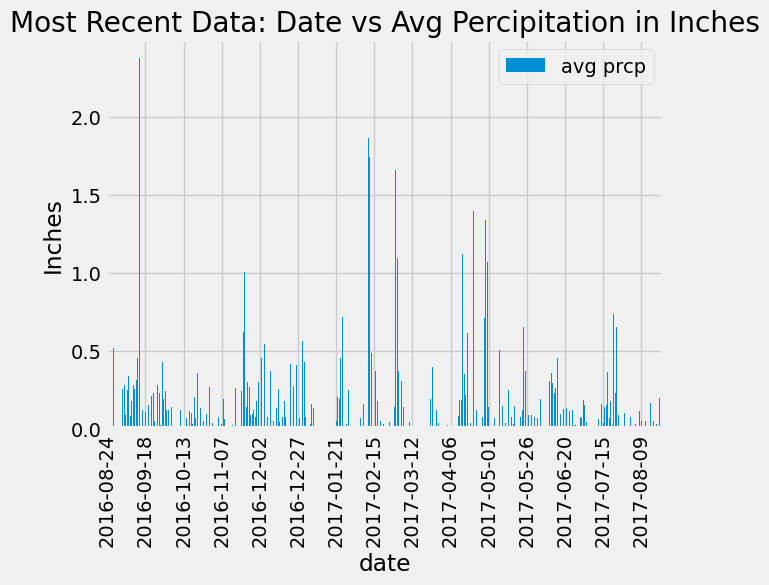

In [112]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
start_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(f"Start date of dataset: {start_date}")

# Perform a query to retrieve the data and precipitation scores
years_data = session.query( measurement.date, measurement.prcp).\
    filter(measurement.date > start_date).all()
type(years_data)
print(f"First entry: {years_data[0]}")

# Save the query results as a Pandas DataFrame and set the index to the date column
column = ['date','prcp']

measurement_df = pd.DataFrame(years_data, columns=column)

measurement_df["date"] = pd.to_datetime(measurement_df["date"]).dt.strftime('%Y-%m-%d') 

#measurement_df.set_index(measurement_df['date'])

# Had to change the outputs to avg of prcp for there are multiple stations with different prcp
df_by_date = measurement_df.groupby(['date'])
grouped_by_date = pd.DataFrame()
grouped_by_date['avg prcp'] = (df_by_date['prcp'].sum())/(df_by_date['prcp'].count())

##measurement_df2 = measurement_df
##measurement_df2 = measurement_df2.set_index(measurement_df2['date'])
##measurement_df2.drop(measurement_df2['date'], axis=1)

# Sort the dataframe by date
grouped_by_date = grouped_by_date.sort_values("date")


# Use Pandas Plotting with Matplotlib to plot the data
grouped_by_date.plot(kind="bar", use_index=True, y="avg prcp")
plt.xticks(np.arange(0, len(grouped_by_date.index)+1, 25))
plt.ylabel("Inches")
plt.title('Most Recent Data: Date vs Avg Percipitation in Inches')
plt.show()


In [29]:
# extract list via json as alternative
#grouped_by_date.drop(grouped_by_date['date'], axis=1)
grouped_by_date.to_json('most_recent_avg_prcp.json')

In [87]:
# Use Pandas to calcualte the summary statistics for the precipitation data
print("AVG DATAFRAME")
print(grouped_by_date.describe())
print("Before AVG")
print(measurement_df.describe())


AVG DATAFRAME
         avg prcp
count  365.000000
mean     0.169987
std      0.295722
min      0.000000
25%      0.008571
50%      0.070000
75%      0.191667
max      2.380000
Before AVG
              prcp
count  2015.000000
mean      0.176462
std       0.460288
min       0.000000
25%       0.000000
50%       0.020000
75%       0.130000
max       6.700000


# Exploratory Station Analysis

In [88]:
# Design a query to calculate the total number stations in the dataset
total_stations = session.query(station.station).count()
total_stations

9

In [89]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = session.query(station.station)
for stations in active_stations:
    print(f"{stations}:")
    print(session.query(measurement).filter(measurement.station == stations[0]).count())

most_active_stations = session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()

most_active_stations

('USC00519397',):
2724
('USC00513117',):
2709
('USC00514830',):
2202
('USC00517948',):
1372
('USC00518838',):
511
('USC00519523',):
2669
('USC00519281',):
2772
('USC00511918',):
1979
('USC00516128',):
2612


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [90]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = 'USC00519281'

lowest_temp = session.query(measurement.station, func.min(measurement.tobs)).filter(measurement.station == most_active_station).all()
highest_temp = session.query(measurement.station, func.max(measurement.tobs)).filter(measurement.station == most_active_station).all()
avg_temp = session.query(measurement.station, func.avg(measurement.tobs)).filter(measurement.station == most_active_station).all()

print(f"Station USC00519281:\nLowest temp: {lowest_temp[0][1]}\nHighest temp: {highest_temp[0][1]}\nAvg temp: {avg_temp[0][1]}")

Station USC00519281:
Lowest temp: 54.0
Highest temp: 85.0
Avg temp: 71.66378066378067


In [91]:
most_recent_date_at_station = session.query(measurement.date).\
    filter(measurement.station == most_active_station).order_by(measurement.date.desc()).first()

most_recent_date_at_station

('2017-08-18',)

Start date of dataset: 2016-08-18
First entry: ('2016-08-20', 81.0)


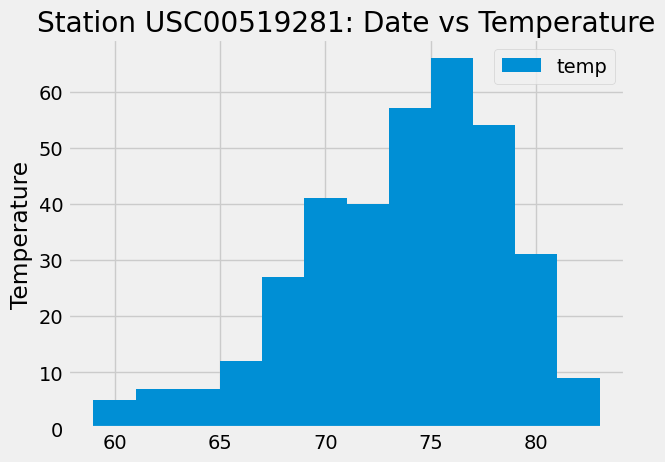

In [107]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

#Find the start date of data queries
start_date = dt.date(2017, 8, 18) - dt.timedelta(days=365)
print(f"Start date of dataset: {start_date}")

# Perform a query to retrieve the data
years_data_for_station = session.query( measurement.date, measurement.tobs).\
    filter(measurement.station == most_active_station).\
    filter(measurement.date > start_date).all()
type(years_data)
print(f"First entry: {years_data_for_station[1]}")

#Create a DataFrame for data
column = ['date','temp']

station_temp_df = pd.DataFrame(years_data_for_station, columns=column)

station_temp_df["date"] = pd.to_datetime(measurement_df["date"]).dt.strftime('%Y-%m-%d') 
station_temp_df.set_index(station_temp_df["date"])

#Plotting
station_temp_df.plot(kind="hist", y="temp", bins=12)
#plt.xticks(np.arange(0, len(station_temp_df["date"])+1, 60))
plt.ylabel("Temperature")
plt.title('Station USC00519281: Date vs Temperature')
plt.show()

# Close session

In [113]:
# Close Session
session.close()